# Lab Three - Clustering


Team Members
* Chance Robinson
* Dan Crouthamel
* Shane Weinstock

# Imports and Setup

This section is for initialization code, imports, etc.

In [1]:
# Base Imports
import pandas as pd
import numpy as np 
import time
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns; sns.set()
%matplotlib inline

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Metrics and Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

# Train/ Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

# KModes/KPrototypes
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

# Pandas Profiling
from pandas_profiling import ProfileReport

# Imbalanced Data
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import BorderlineSMOTE
# from imblearn.pipeline import make_pipeline, Pipeline

# Estimators
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier

# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# T-Tests
# from mlxtend.evaluate import paired_ttest_5x2cv

# Machine Learning Visualizations
# from yellowbrick.classifier import ROCAUC
# from yellowbrick.classifier import PrecisionRecallCurve
# from yellowbrick.classifier import ClassificationReport

plt.style.use("ggplot")

# Business Understanding 1


_Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?_

The goal of this project is to explore clustering as a means of feature engineering and how it can be used, if at all, to improve the performance of a classification model, which is to predict the presence of Cardiovascular disease. The dataset used was obtained from Kaggle, available via the source below.

https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

The dataset contains 11 features and 1 target variable as defined below in Table 1. It's important to note that this dataset seems to be an academic dataset, and is not derived from any real world clinical scenario. Nevertheless, it makes for a good dataset to learn with.

**Table 1: Cardiovascular Dataset - Attribute Descriptions**

| Column Description | Feature Type | Column Name | Data Type |
|:---|:---|:---|:---|
| **Age**                        | Objective | age | int (days) |
| **Height**                     | Objective | height | int (cm) |
| **Weight**                     | Objective | weight | float (kg) |
| **Gender**                     | Objective | gender | 0: female, 1: male |
| **Systolic blood pressure**    | Examination | ap_hi | int |
| **Diastolic blood pressure**   | Examination | ap_lo | int |
| **Cholesterol**                | Examination | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| **Glucose**                    | Examination | gluc | 1: normal, 2: above normal, 3: well above normal |
| **Smoking**                    | Subjective  | smoke | binary |
| **Alcohol intake**             | Subjective | alco | binary |
| **Physical activity**          | Subjective | active | binary |
| **Has CVD?**                   | Target | cardio | binary |

## Load Data

# Data Understanding 1

_Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?_

Below we will load in the data, drop duplicates, and output information about the dataset. We can see that none of the features have a null value. All features are of type integer, with the exception of weight being a float.

We can conceptually divide this set up into numerical and categorical featuers.

__Numeric__

* Age
* Height
* Weight
* Systolic Blood Pressure (High Number)
* Diastolic Bloow Pressure (Low Number)

__Categorical__

* Cholesterol
* Glucose
* Smoking
* Alcohol Consumption
* Active

The target variable, 'cardio', is binary to indicate No (0) or Yes (1) with respect to having Cardiovascular disease.

In [2]:
df = pd.read_csv('../../../data/cardio_train.csv', delimiter=';')
# set id as index
df.set_index("id", inplace=True)

# copy original data
df_clean = df.copy(deep=True)

# drop duplicates
df_clean.drop_duplicates(inplace=True)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69976 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  int64  
 1   gender       69976 non-null  int64  
 2   height       69976 non-null  int64  
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  int64  
 5   ap_lo        69976 non-null  int64  
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


## Apply Transformations

Below we will encode gender as 0 and 1, instead of 1 and 2. This gives the added benefit of being able to interpret things easier in the df.describe() call below.

In [3]:
# re-encode gender to male (1) and female (0)
df_clean['gender'] = np.where((df_clean.gender == 2), 1, 0)

In [4]:
df_clean.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,0.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,0.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


The above can actually tells us a lot about our data set. We can glean the following.

* 35% of the set is Male
* 80% of the set is Active
* 8.81% of the set is a Smoker
* 5.38% of the set uses Alcohol
* Balanced set with respect to target variable 'cardio'

We can see an issue immediately with our ap_hi and ap_low features, having negative values. However, interstingly enough, the median values for ap_hi and ap_lo are 120 and 80 respectivley, ideal values for a healthy individual. Let's explore them a bit more.

The below uses Pandas Profiling, which generates an interactive UI for exploring variable features. The Warnings widget confirms our suspician indicating that ap_hi and ap_lo are highly skewed. Note, we included a screenshot of the Pandas profiling widget since they widget may not always display, unless when running the notebook.

In [5]:
profile = ProfileReport(df_clean, title="Pandas Profiling Report")
profile.to_widgets()

Generate report structure: 100%|█████████████████| 1/1 [00:02<00:00,  2.18s/it]


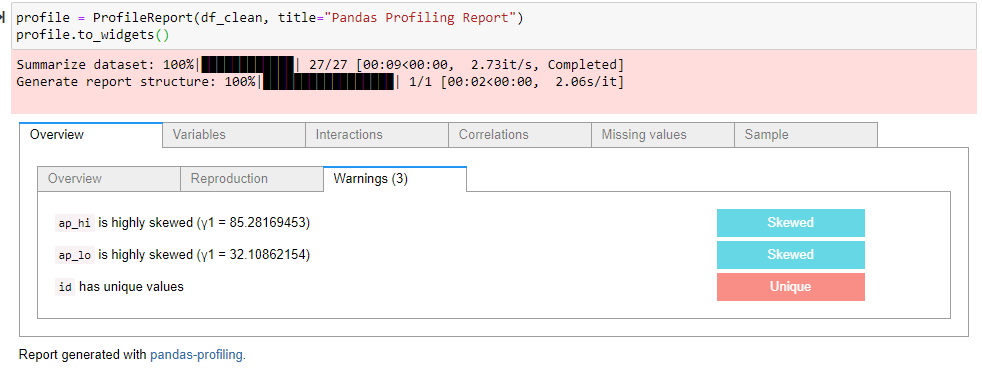

In [6]:
from IPython.display import Image
Image(filename='Pandas.png') 

In our previous labs, we binned ap hi and lo into buckets. We'll instead here leave them as they are, but replace certain values with the mean.

Note, a more complete cleaning could have been done. Upon inspection, we see values that are incorrect, because of decimal issues and some values including both the hi and lo reading in one. For example, the max value for ap_lo is 11000. Should this really be 110 instead?

__Ap Hi__
* If > 200 replace with ap_hi medina (120)
* If < 80 (median for ap_lo), replace with ap_hi median (120)

__Ap Lo__
* If > 120 (median for hi), replace with ap_lo median (80)
* If < 0 replace with ap_lo median (80)

In [7]:
# If > 200, replace with ap_hi median (120)
# If < 80 (median for ap_lo), replace with ap_hi median (120)
df_clean['ap_hi'] = np.where(df_clean['ap_hi'] > 200, 120, df_clean['ap_hi'])
df_clean['ap_hi'] = np.where(df_clean['ap_hi'] < 80, 120, df_clean['ap_hi'])

# If > 120 (median for hi), replace with ap_lo median (80)
# If < 0 replace with ap_lo median (80)
df_clean['ap_lo'] = np.where(df_clean['ap_lo'] > 120, 80, df_clean['ap_lo'])
df_clean['ap_lo'] = np.where(df_clean['ap_lo'] < 0, 80, df_clean['ap_lo'])

# Data Understanding 2


_Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs._

Pandas profiling above provides a quick correlation heatmap. The below pulls in the image of that output.

The following correlations can be gleaned from the output

* Height and Gender
* Gender and Smoking
* Alcohol and Smoking
* Glucose and Cholesterol

Additionally, we see the following are more strongly correlated with out target variable, 'cardio'.

* Age
* Weight
* Blood Pressure (High/Low)
* Cholesterol

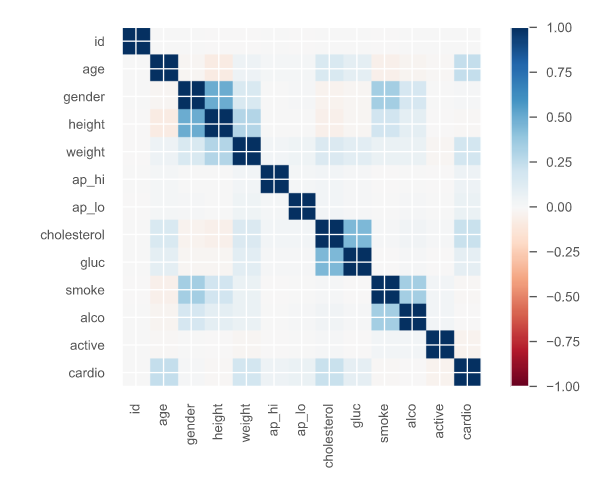

In [8]:
from IPython.display import Image
Image(filename='Correlation.png') 

Below shows a scatter plot between the ap hi and lo features, colored by our response variable. It does look like this could be a good set of features to cluster with.

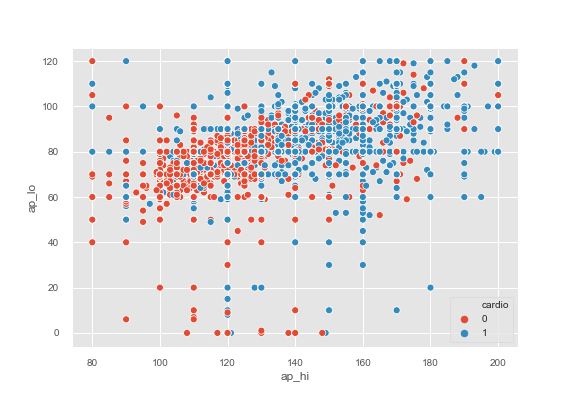

In [9]:
# ax = sns.scatterplot(x="ap_hi", y="ap_lo", hue="cardio", data=df_clean)
# ax.figure.savefig("./img/ap_hi_lo_scatterplot.png")
from IPython.display import Image
Image(filename='./img/ap_hi_lo_scatterplot.png') 

# Modeling and Evaluation 1


_Train and adjust parameters_

Before moving onto the clustering algorithms, we'll generate a baseline model in which to compare against. In this case we'll use Logistic Regression model. This model provides baseline a ROC score of 79.2 and an accuracy of 72.8.

In [10]:
# create an empty list to store model parameters for comparisons
model_comparisons = []

### Baseline Classification Performance

In [11]:
%%time
from sklearn.model_selection import StratifiedKFold, cross_val_score

numeric_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

# Impute Numeric Features with the mean value

# One Hot Encode Categorical Features

# Robust Scaler
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df_clean[["age", "height", "weight", "ap_hi", "ap_lo"]] = rs.fit_transform(df_clean[["age", "height", "weight", "ap_hi", "ap_lo"]])


X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

y = df_clean['cardio']
X = df_clean[X_cols]
cv = StratifiedKFold(n_splits=10)

clf_logreg = LogisticRegression(random_state=1, penalty='l2', C=.01)
roc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='roc_auc')
acc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='accuracy')

print ("Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)
print ("Average Accuracy = ", acc.mean()*100, "+-", acc.std()*100)


model_comparisons.append({"model": "baseline", 
                          "no_of_clusters": "NA",
                          "roc_auc_mean": round(roc.mean()*100, 3), 
                          "roc_standard_deviation": round(roc.std()*100, 3),
                          "acc_mean": round(acc.mean()*100, 3),
                          "acc_standard_deviation": round(acc.std()*100, 3),
                          "wall_time": "~ 2 seconds"})

Average ROC (AUC) =  79.1507617264313 +- 0.5833047553922216
Average Accuracy =  72.83353973243668 +- 0.3927198719764307
Wall time: 2.04 s


### Clustering Methods

We'll explore the following clustering methods on our dataset, and see if any of them can be used to improve our classification performance.

* K-means
* Mean Shift
* Gaussian Mixtures
* Agglomerative
* DBScan

__Important - We will run/load all algorithms in the section, and then discuss as approrpiate in the following sections.__

## K-Means


__Summary:__

The K-Means algorithm is a partitional model that iteratively assigns data points to one of K clusters based on a cluster’s centroid (or central point).  The steps for mapping the ideal clusters are summarized below.

__Steps:__

1.      Select K points as the initial centroids.
2.      repeat
3.      Form K clusters by assigning all points to the closest centroid.
4.      Recompute the centroid of each cluster.
5.      until The centroids don't change

Listed below are some of the main limitations of the k-means clustering algorithm, none of which seem likely to pose inherent risks to the parameters of interest we’ll be applying the clustering algorithm to.


__Limitations:__

 - Clusters are different sizes
 - Clusters have different densities
 - Clusters' shapes are nonglobular


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
cv = StratifiedKFold(n_splits=10)

### Systolic blood pressure	(ap_hi) and Diastolic blood pressure (ap_lo)

In [13]:
X1 = df_clean[['ap_hi','ap_lo']]

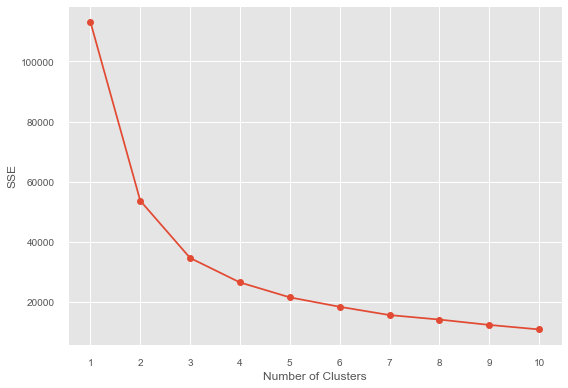

In [14]:
sse = []
# silhouette_coefficients = []

for i in range(1, 11):
    km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=1)
    km.fit(X1)
    # score = silhouette_score(X1, km.labels_)
    sse.append(km.inertia_)
    # silhouette_coefficients.append(score)

plt.plot(range(1, 11), sse, marker='o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.tight_layout()
plt.show()

Using the elbow plot based on the SSE score would indicate that the ideal number of clusters for the combined `ap_hi` and `ap_lo` features would be three.

In [15]:
from kneed import KneeLocator

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

n_clusters = kl.elbow
n_clusters

3

The `KneeLocator` library can be used to validate our visual inspection.

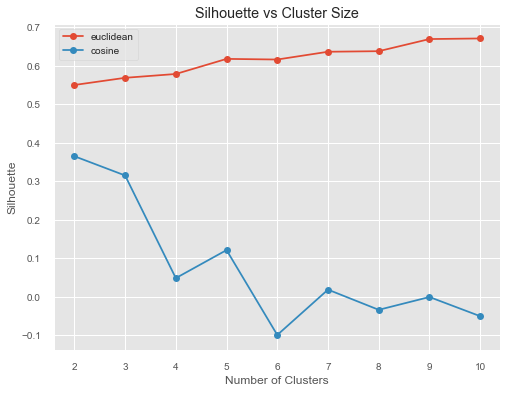

In [16]:
seuclid = [0.5502656133785342, 0.5689314065603147, 0.5788817527521538, 0.6181464595561297, 0.6164950439597074, 0.6367221358063109, 0.638186625559535, 0.6697367320789785, 0.6712569260609158]
scosine = [0.3650401874683305, 0.31496939123233586, 0.048018121602628625, 0.12095189567109092, -0.09983319761340129, 0.018072140321945845, -0.034411066685175205, -0.0011221840014091148, -0.050971566463088584]

# for i in range(2, 11):
#     km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=1, n_jobs=-1)
#     km.fit(X2)
#     seuclid.append(silhouette_score(X2, km.labels_, metric='euclidean'))
#     scosine.append(silhouette_score(X2, km.labels_, metric='cosine'))

# print("Euclidean:", seuclid)
# print("Cosine:", scosine)

plt.figure(figsize=(8,6))
plt.plot(range(2, 11), seuclid, marker='o', label='euclidean')
plt.plot(range(2, 11), scosine, marker='o', label='cosine')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette")
plt.title("Silhouette vs Cluster Size")
# plt.tight_layout()
plt.legend()
plt.show()

The silhouette score however paints a different picture, and would indicate that we can still get an improved score by increasing the number of clusters.  It is also important to reiterate that our main objective here is to utilize the new feature created by combining the continuous `ap_hi` and `ap_lo` parameters and applying that to our classification problem.  

Because of that, the elbow and silhouette plots may be misleading and brute force grid search techniques may be more appropriate to the task at hand.

In [17]:
%%time

n_clusters = 22

# for i in range(20, 24):
km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=1)
km.fit(X1)
new_feature = km.labels_ # the labels from k-means clustering

y = df_clean['cardio']
X = df_clean[['age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]

X = np.column_stack((X, pd.get_dummies(new_feature)))

roc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='roc_auc')
acc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='accuracy')

print ("Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)
print ("Average Accuracy = ", acc.mean()*100, "+-", acc.std()*100)


model_comparisons.append({"model": "kmeans", 
                          "no_of_clusters": n_clusters,
                          "roc_auc_mean": round(roc.mean()*100, 3), 
                          "roc_standard_deviation": round(roc.std()*100, 3),
                          "acc_mean": round(acc.mean()*100, 3),
                          "acc_standard_deviation": round(acc.std()*100, 3),
                          "wall_time": "~ 6 seconds"})

Average ROC (AUC) =  79.32915578735226 +- 0.5158655654458918
Average Accuracy =  72.83067360392032 +- 0.38295366248650176
Wall time: 5.05 s


We attempted many combinations of `n_clusters` but for the sake of processing time they have been excluded from the code.  The best parameter fits have been included in this and subsequent models.

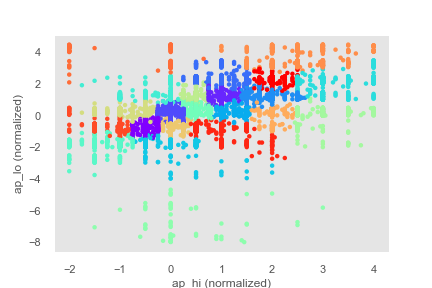

In [18]:
# plt.figure()
# # plt.subplot(1,2,1)
# X1=X1.values
# plt.scatter(X1[:, 0], X1[:, 1]+np.random.random(X1[:, 1].shape)/2, c=new_feature, cmap=plt.cm.rainbow, s=20, linewidths=0)
# plt.xlabel('ap_hi (normalized)'), plt.ylabel('ap_lo (normalized)')
# plt.grid()
# plt.savefig("./img/kmeans_ap_hi_lo_clusters.png")
from IPython.display import Image
Image(filename='./img/kmeans_ap_hi_lo_clusters.png') 

## Mean Shift


__Summary:__

Mean shift is another centroid based algorithm which can detect the number of clusters automatically based on an estimated bandwidth parameter.  

__Steps:__
1.      Define initial regions
2.      Update candidates for centroids for the mean of points in a region
3.      Delete overlapping regions to form the final set of centroids
4.      Assign points based on their region

__Limitations:__

According to the sklearn documentation, it is not scalable for data sets with a large number of samples due to the fact that it requires multiple nearest neighbor searches during runtime.


In [19]:
%%time
from sklearn.cluster import MeanShift, estimate_bandwidth

X1 = df_clean[['ap_hi','ap_lo']]

y = df_clean['cardio']
X = df_clean[['age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X1, quantile=0.05, n_samples=500, n_jobs=-1, random_state=1)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms.fit(X1)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

X = np.column_stack((X, pd.get_dummies(labels)))

roc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='roc_auc')
acc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='accuracy')

print ("Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)
print ("Average Accuracy = ", acc.mean()*100, "+-", acc.std()*100)

model_comparisons.append({"model": "mean_shift", 
                          "no_of_clusters": n_clusters_,
                          "roc_auc_mean": round(roc.mean()*100, 3), 
                          "roc_standard_deviation": round(roc.std()*100, 3),
                          "acc_mean": round(acc.mean()*100, 3),
                          "acc_standard_deviation": round(acc.std()*100, 3),
                          "wall_time": "~ 32 seconds"})

number of estimated clusters : 154
Average ROC (AUC) =  78.94338909898822 +- 0.5381981228929272
Average Accuracy =  72.51056519833777 +- 0.3690903181516195
Wall time: 29.9 s


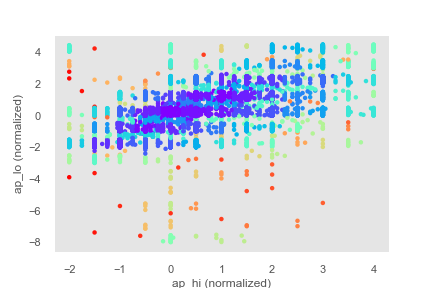

In [20]:
# plt.figure()
# X1=X1.values
# plt.scatter(X1[:, 0], X1[:, 1]+np.random.random(X1[:, 1].shape)/2, c=labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
# plt.xlabel('ap_hi (normalized)'), plt.ylabel('ap_lo (normalized)')
# plt.grid()
# plt.savefig("./img/mean_shift_ap_hi_lo_clusters.png")
from IPython.display import Image
Image(filename='./img/mean_shift_ap_hi_lo_clusters.png') 

## Gaussian Mixtures


__Summary:__

This modelling method makes the assumption that there’s an underlying distribution in our data. This underlying distribution is defined by the items below:

The formula is defined as: px(i),z(i)=px(i)|z(i)pz(i)

- A "mixture" is just a Gaussian probability and a weight.
    - The weight is a class prior.
- We assume that we can observe x from an unknown label z:
    - x(i): the instance from the modelo
    - z(i): some unknown class labeling
- Assumptions:
    - Conditional probability follows a normal distribution
    - pz(i)=j=wjoΣ j = 1 K wj =1
    
    
The weight is derived from the previous class and is normally stored as a latent or hidden variable. This weight helps define the probability and the underlying distribution of the data. All of this tells us how likely it is to find our point based on these values.

Likelihood of each x is given by marginalization (i.e., the sum of all the mixtures)
- lx(i)=Σj=1Kp x(i) | z(i)=jp z(i)=j
- Total likelihood of a set of X = {x(1), x(2), ... ,x(m)}
- lX=Πi=1mΣj=1Kp x(i) | z(i)=jp z(i)=j


This can be simplified to:

- l=Πi=1mΣj=1Kpx(i)|z(i)=jwj

Unless it’s multivariate which would be defined by:

- =1(2π)k|Σ|exp-12(x-μ)TΣ-1x-μ

    - If N is the number of attributes (i.e., the length of each vector x)
    - Mean has N parameters
    - Covariance has N2 parameters
    - For K Gaussians, we have K×N+K×N2 parameters to estimate
    - Simplify the number of parameters by limiting the expressiveness of each Gaussian



In [21]:
%%time

from sklearn.mixture import GaussianMixture

X1 = df_clean[['ap_hi','ap_lo']]

y = df_clean['cardio']

# n_components_range = range(20, 28)  commenting out as the best params have already been identified
# cv_types = ['spherical', 'diag', 'full']  
n_components_range = range(20, 21)
cv_types = ['diag']

for cv_type in cv_types:
    for n_components in n_components_range:
        X = df_clean[['age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
        gm = GaussianMixture(n_components=n_components, covariance_type=cv_type, random_state=1)
        labels = gm.fit_predict(X1)

        X = np.column_stack((X, pd.get_dummies(labels)))

        roc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='roc_auc')
        acc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='accuracy')

        print ("Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)
        print ("Average Accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        
        
        model_comparisons.append({"model": "gaussian_mixture", 
                                  "no_of_clusters": "20",
                                  "roc_auc_mean": round(roc.mean()*100, 3), 
                                  "roc_standard_deviation": round(roc.std()*100, 3),
                                  "acc_mean": round(acc.mean()*100, 3),
                                  "acc_standard_deviation": round(acc.std()*100, 3),
                                  "wall_time": "~ 6 seconds"})


# Average ROC (AUC) =  22 spherical 79.22755021024786 +- 0.5020973284084818
# Average ROC (AUC) =  20 diag 79.2318657110504 +- 0.5090075792794152
# Average ROC (AUC) =  27 full 79.13429282955636 +- 0.5369306563066206


Average ROC (AUC) =  79.2318657110504 +- 0.5090075792794152
Average Accuracy =  72.84782095196721 +- 0.300894160486455
Wall time: 5.36 s


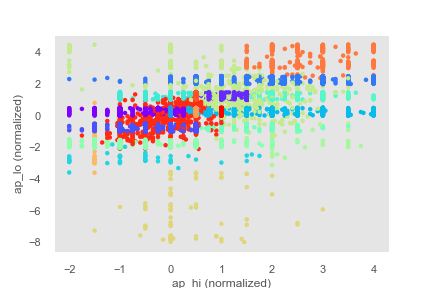

In [22]:
# plt.figure()
# # plt.subplot(1,2,1)
# X1=X1.values
# plt.scatter(X1[:, 0], X1[:, 1]+np.random.random(X1[:, 1].shape)/2, c=labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
# plt.xlabel('ap_hi (normalized)'), plt.ylabel('ap_lo (normalized)')
# plt.grid()
# plt.savefig("./img/gaussian_mixture_ap_hi_lo_clusters.png")
from IPython.display import Image
Image(filename='./img/gaussian_mixture_ap_hi_lo_clusters.png') 

## Hierarchical Clustering

__Summary:__

Hierarchical clustering algorithms are normally sorted into top-down or bottom-up algorithms. They are generally the most common type of hierarchical clustering methods. Algorithms start by treating individual objects as singleton clusters and then begin to pair clusters and successively merge them until all clusters can be merged into one over-branching cluster. This then results in a dendrogram or tree based representation of clusters.

__Steps:__
1.      Compute the proximity matrix
2.      Let each data point be a cluster
3.      Repeat
4.      Merge the two closest clusters
5.      Update the proximity matrix
6.      Until only a single cluster remains


Where we have to compute the distance between each cluster or point. We can approach this by min(single link), max (complete linkage), group average, the distance between centroids, or the objective function-based methods (such as Ward’s methods, which utilizes the squared error).


__Limitations:__

- Requires O(N2) space to store proximity matrix
- Computationally complex (complexity is O(N3) in many cases)
- Proximity matrix (whose size is N2) is updated and searched at each of N steps
- Complexity can be reduced to O(N2 log(N)) using kd-trees
- Cannot undo decision to combine two clusters
  - It doesn’t really provide us anything additional on top of K Means. We generally observe this because no objective function can be identified.
- Does not directly minimize any objective function

Constraints can be used to help agglomerative clustering become more powerful. Some additional methods that may be useful are:

- Sensitivity to noise and outliers
- Handling different sized clusters and convex shapes
- Breaking up large clusters

In [23]:
%%time

from sklearn.cluster import AgglomerativeClustering

y = df_clean['cardio']
X = df_clean[X_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# X1 = X_train[['height','weight']]
X1 = X_train[['ap_hi','ap_lo']]

# X = X_train[['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
X = X_train[['age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
y = y_train

# append on the clustering
cls_fam = AgglomerativeClustering(n_clusters=3, linkage="ward")
cls_fam.fit(X1)
new_feature = cls_fam.labels_ # the labels from kmeans clustering

X = np.column_stack((X, pd.get_dummies(new_feature)))

roc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='roc_auc')
acc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='accuracy')

print ("Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)
print ("Average Accuracy = ", acc.mean()*100, "+-", acc.std()*100)

model_comparisons.append({"model": "Hierarchical Clustering", 
                          "no_of_clusters": "3",
                          "roc_auc_mean": round(roc.mean()*100, 3), 
                          "roc_standard_deviation": round(roc.std()*100, 3),
                          "acc_mean": round(acc.mean()*100, 3),
                          "acc_standard_deviation": round(acc.std()*100, 3),
                          "wall_time": "1min 4s"})


Average ROC (AUC) =  76.70701109903784 +- 0.9348625164936255
Average Accuracy =  70.78173802521842 +- 0.714826664077089
Wall time: 1min 2s


In [24]:
import scipy.cluster.hierarchy as sch

# Comment out to prevent running again, takes a long time.
#hc_ward = sch.linkage(X, method='ward')

#dendrogram = sch.dendrogram(hc_ward)

In [25]:
#dendrogram = sch.dendrogram(hc_ward)

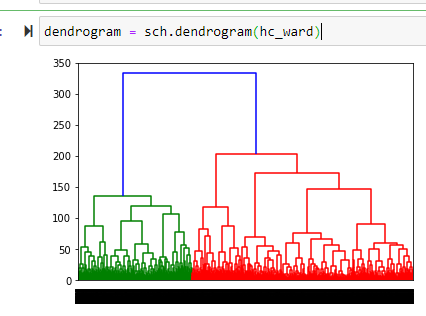

In [26]:
from IPython.display import Image
Image(filename='./img/Dendro.png') 

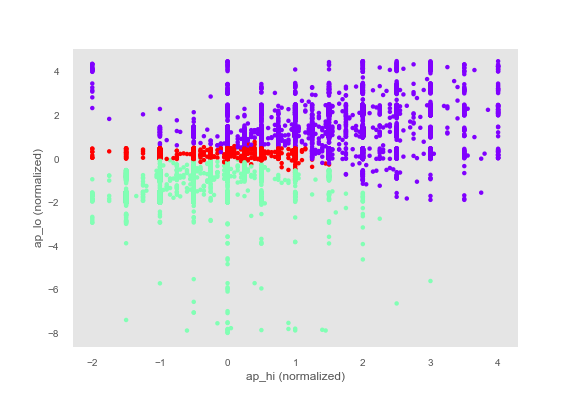

In [27]:
# plt.figure()
# X1=X1.values
# plt.scatter(X1[:, 0], X1[:, 1]+np.random.random(X1[:, 1].shape)/2, c=new_feature, cmap=plt.cm.rainbow, s=20, linewidths=0)
# plt.xlabel('ap_hi (normalized)'), plt.ylabel('ap_lo (normalized)')
# plt.grid()
# plt.savefig("./img/HC.png")

from IPython.display import Image
Image(filename='./img/HC.png') 

## DBSCAN

__Summary:__

DBSCAN is a non-parametric algorithm that is able to group points based on density (determined by KNN). It requires some input to ensure that the noise and desired density or distances are appropriate. The algorithm is very sensitive overall and requires some adjusting in order to make it effective.

- __Core point:__ point that has more than a specific number of points (MinPts) within a specified radius (Eps)
- __Border point:__ point that has fewer than MinPts within Eps but is in the neighborhood of a core point
- __Noise point:__ any point that is not a core or border point

__Steps:__

In the process for DBSCAN, we would first identify the border and noise points and then throw them out. We only really want to evaluate the core points. We then label all the core points, looking for all points within Eps of that core point and all core points that are around it. This process can be summarized in the following steps as well:

1.      Run after labeling core, border, and noise points
2.      Labels unlabeled core points
3.      Connects all core points within Eps

__Limitations:__

DBSCAN does not perform well when:

- Varying desnities are present in the data
- High dimensionality within the data
- Determining Eps which is shown below:
  - Calculate Kth nearest neighbors for all points in data set.
  - Save distance of farthest neighbor.
  - Plot sorted distance of every point to its Kth nearest neighbor.
- Determining MinPts
  - Although this is commonly just set to what works empirically to the data.

In [28]:
%%time 
from sklearn.cluster import DBSCAN

X1 = df_clean[['ap_hi','ap_lo']]

params = []
for eps in [0.05]:
    for mpts in range(3, 4):

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts, n_jobs=-1)
        cls_fam.fit(X1)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_clean['cardio']
        X = df_clean[['age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        roc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='roc_auc')
        acc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='accuracy')

        print ("Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)
        print ("Average Accuracy = ", acc.mean()*100, "+-", acc.std()*100)

        model_comparisons.append({"model": "DBSCAN", 
                          "no_of_clusters": "NA",
                          "roc_auc_mean": round(roc.mean()*100, 3), 
                          "roc_standard_deviation": round(roc.std()*100, 3),
                          "acc_mean": round(acc.mean()*100, 3),
                          "acc_standard_deviation": round(acc.std()*100, 3),
                          "wall_time": "30 seconds"})


Average ROC (AUC) =  78.66738788227941 +- 0.5569878281318702
Average Accuracy =  72.26477374474334 +- 0.39733087759246744
Wall time: 31.3 s


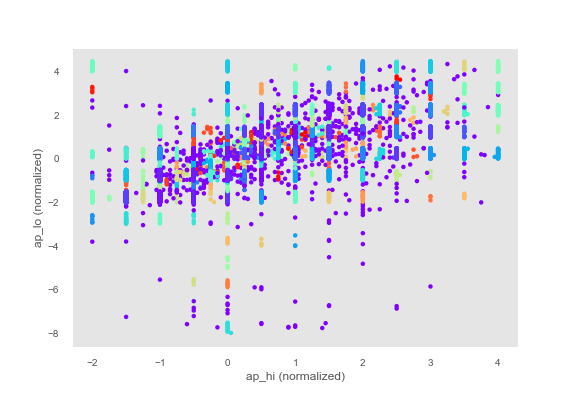

In [29]:
# plt.figure()
# X1=X1.values
# plt.scatter(X1[:, 0], X1[:, 1]+np.random.random(X1[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
# plt.xlabel('ap_hi (normalized)'), plt.ylabel('ap_lo (normalized)')
# plt.grid()
# plt.savefig("./img/DBScan.png")

from IPython.display import Image
Image(filename='./img/DBScan.png') 

# Modeling and Evaluation 2


_Evaluate and Compare_


In [30]:
df_model_comparisons = pd.DataFrame(model_comparisons)

In [31]:
df_model_comparisons

,model,no_of_clusters,roc_auc_mean,roc_standard_deviation,acc_mean,acc_standard_deviation,wall_time
0,baseline,NA,79.151,0.583,72.834,0.393,~ 2 seconds
1,kmeans,22,79.329,0.516,72.831,0.383,~ 6 seconds
2,mean_shift,154,78.943,0.538,72.511,0.369,~ 32 seconds
3,gaussian_mixture,20,79.232,0.509,72.848,0.301,~ 6 seconds
4,Hierarchical Clustering,3,76.707,0.935,70.782,0.715,1min 4s
5,DBSCAN,NA,78.667,0.557,72.265,0.397,30 seconds


All models are within range of one another in terms of the metrics that were judged upon.  What did differ more drastically however were the time requirements.  Hierarchical Clustering performed much more poorly when compared to the other models within this set of clustering algorithms.  Incidentally, it also was the worst performer in terms of scoring metrics.

# Modeling and Evaluation 3


_Visualize Results_

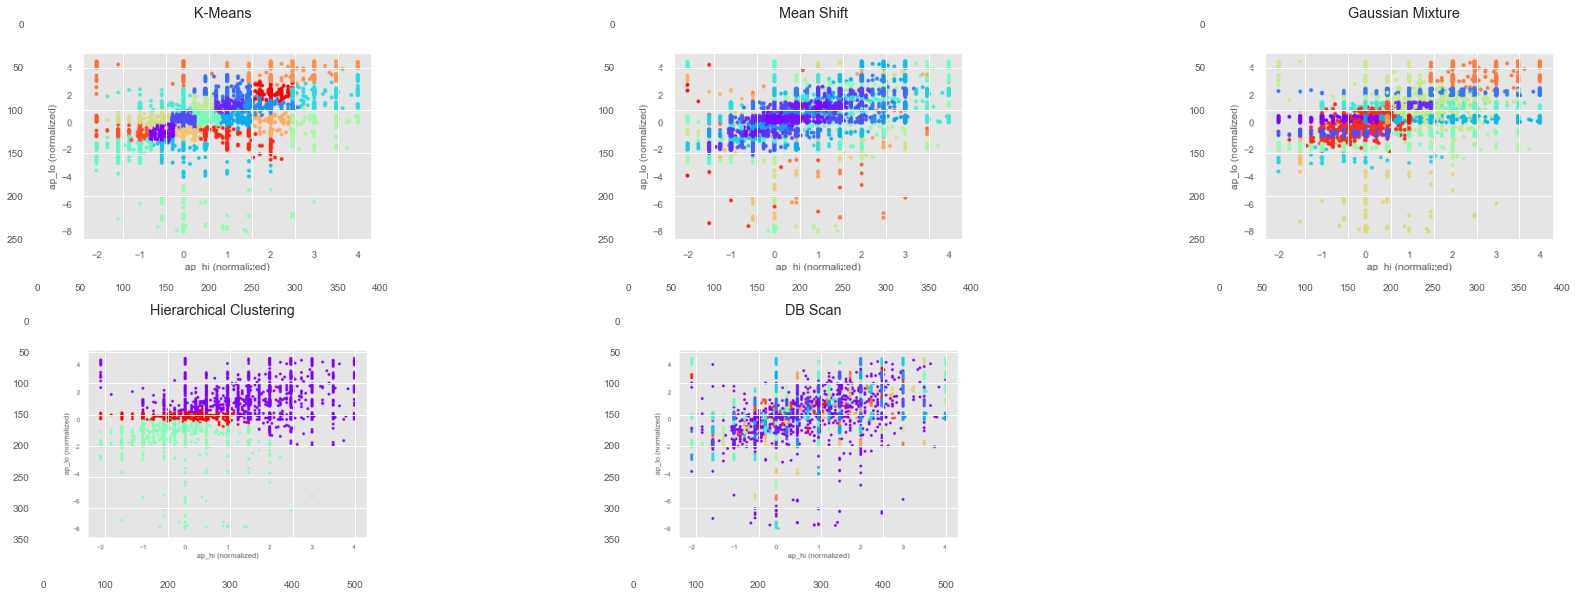

In [32]:
fig_1 = plt.figure(1, figsize=(30, 10))

import matplotlib.image as mpimg

img1 = mpimg.imread('./img/kmeans_ap_hi_lo_clusters.png')
img2 = mpimg.imread('./img/mean_shift_ap_hi_lo_clusters.png')
img3 = mpimg.imread('./img/gaussian_mixture_ap_hi_lo_clusters.png')
img4 = mpimg.imread('./img/HC.png')
img5 = mpimg.imread('./img/DBScan.png')


plt.figure(1)
plt.subplot(231)
plt.imshow(img1)
plt.title("K-Means")

plt.subplot(232)
plt.imshow(img2)
plt.title("Mean Shift")

plt.subplot(233)
plt.imshow(img3)
plt.title("Gaussian Mixture")

plt.subplot(234)
plt.imshow(img4)
plt.title("Hierarchical Clustering")

plt.subplot(235)
plt.imshow(img5)
plt.title("DB Scan")

plt.show()

The graphs show fairly disparate results visually, which is surprising considering many of the models are relatively close to one another in terms of their metric scores.  It's also worth noting that two of the better performing models had similar categorizations.  K-Means and the Gaussian Mixture Model graphs certainly look more like one another than the others.

# Modeling and Evaluation 4

_Summarize the Ramifications_


Does clustering help in the predictive capabilities of our baseline classification model?  The answer is yes, albeit slightly and depending on the classification algorithm chosen.  Without having any ground truth to base our labels on, it's hard to gauge whether or not any of these techniques are picking out better clusters or bins over what an expert in the field might suggest.

The baseline logistic regression model we’re comparing against used both the `ap_hi` and `ap_lo` variables, with the same outlier imputation and scaling strategies.  Although some of clustering techniques outperformed the original parameters, they likely did not perform statistically better than our binning approach from labs one and two which grouped the two parameters into 5 discreet groups.  

Furthermore, these strategies were based on charts from the American Heart Association and are arguably easier to interpret.  [Source](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings)  Perhaps there are other sets of data where this technique would yield better results above and beyond what could be achieved through normal feature engineering approaches, but ultimately the one applied here is arguably not wort the effort.


# Deployment 


_Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?_

For the cardiovascular disease dataset, the models analyzed do not achieve ROC AUC values greater than 0.7932 using KMeans.  This suggests that the models would not be very useful for interested parties. These models could alleviatesome weight for identifying cardiovascular disease, but could not be adopted blindlyor trusted entirely. With a much lower identification/classification than a healthcare professional (under current data and constraints).

In the cardiovascular disease dataset, the ROC AUC values indicate that there is a high amount of false-positive results. Specifically, approximately 20% of the data is indicative of a false positive result from using this model. This equates to treating cardiovascular disease in which 20% of the patients likely do not have cardiovascular disease. If someone was identified to have cardiovascular disease when they in fact did not (false positive), these medications that help in the case of cardiovascular disease could cause even worse health situations or conditions. Additionally, if a patient was evaluated and was classified negative for cardiovascular disease, but was actually positive (false negative), they would likely experience an even greater decline in their health. 

These percentages would be too great with the known harmful results, it is unlikely that the model used to predict cardiovascular disease and would be adopted or deployed. There may be an instance where it is used in conjunction with the classification or identification process of another procedure (likely conducted by a human element or healthcare professional). However, as a standalone process to empirically identify or classify cardiovascular disease, the current models developedare not sufficient. If the model for the cardiovascular disease dataset were to be deployed, the value of the model would be measured by the number of patients that do not have cardiovascular disease but were treated for cardiovascular disease.The model used for the cardiovascular disease dataset would be deployed inside a hospital setting, and accessible at a nurse’s station. This would allow a nurse to input the relevant data, run the model, and provide results to a doctor for analysis. 

Other data that may be collected to improve the performance of the model may include such measurements as commonly used for diagnosing cardiovascular disease. These may include lipids, proteins or other, known causes of cardiovasculardisease. (https://www.ahajournals.org/doi/full/10.1161/01.CIR.0000114134.03187.7B). The model would need to be updated every time a person suffering cardiovascular disease is admitted or visits the hospital. This would provide more data for the model to evaluate and predict and may improve usefulness.

# Exceptional Work


_You have free reign to provide additional analyses or combine analyses._

## K-Prototypes

__Important - The output below is pulled from screenshots to prevent repeated excecution of this code. We are clustering the ENTIRE set. This is really just an academic exercise. It takes a long time to run, several hours.__

In this section we'll explore the KModes package, which supports k-modes and k-prototypes clustering algorithms. More information about this package can be found via the link below.

https://pypi.org/project/kmodes/

k-modes can be used to cluster categorical features. Clusters are defined by matching categories between data points, unlike k-means which is based on Euclidean distance and is really meant for numerical data. k-prototypes provides the ability to cluster both numerical and categorical data. Think of it as k-means for numeric, and k-modes for categorical.

Our dataset consists of 5 numerical features and 5 categorical features, along with 1 binary target. We'll use k-prototypes to cluster our entire data set including target, varying the number of clusters and determine which cluster size produces a better prediction accuracy for our classification task. We'll compare that against metrics for optimal number of clusters.

The implementation of k-prototypes can be found here.
https://github.com/nicodv/kmodes/blob/master/kmodes/kprototypes.py
Huang, Z.: Extensions to the k-modes algorithm for clustering large
    data sets with categorical values, Data Mining and Knowledge
    Discovery 2(3), 1998.

Kprototypes supports two different methods for initialization, 'Haung' and 'Cao'. The code below will use Huang.

Huang - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf  
Cao - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.474.8181&rep=rep1&type=pdf

The two papers referenced above are a good resource. At a high level, the Cao initialization method takes into account the distance between objects as well as the density of the object, in contrast to Huang which does not consider density.


The dissimilarity measure is given by the below. This text was taken from the reference mentioned below.

D(x,p) = E(x,p) + λ C(x,p)

Where
* x = Any datapoint
* y = Prototype of a cluster
* D(x,p) = Dissimilarity measure between x and y
* E(x,p) = Euclidean distance between continuous attributes of x and y
* C(x,p) = number of mismatched categorical attributes between x and y
* λ = weightage for categorical variable value

Reference:
https://medium.com/@guruprasad0o_o0/notes-on-k-prototype-for-clustering-mixed-typed-data-e80eb526b226

In [33]:
df_modes = df_clean.copy()
df_modes.reset_index(drop=True, inplace=True)
df_modes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  float64
 1   gender       69976 non-null  int32  
 2   height       69976 non-null  float64
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  float64
 5   ap_lo        69976 non-null  float64
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
dtypes: float64(5), int32(1), int64(6)
memory usage: 6.1 MB


Below we will use K-Prorotypes to cluster our __ENTIRE__ data set, using 2 to 10 clusters. This is an expensive call and will take awhile to run. Maximum iterations is 100 by default. We could try lowering that to 50.

In [ ]:
# Define categorical features by index
categories = [1,6,7,8,9,10,11]

ks = range(2, 11)
centroids = []
features = []  #labels
costs = []
epoch_costs = []
gammas = []
seuclid = []
shamming = []

for k in ks:
    clf = KPrototypes(n_clusters=k, init='Huang', n_init=5, n_jobs=-1, random_state=1)
    #clf = KModes(n_clusters=2, init='Huang', n_init=5, n_jobs=-1)
    pipe = Pipeline([['ss', StandardScaler()],
                    ['clf', clf]])

    # Fit model to samples
    pipe.fit(df_modes, clf__categorical=categories)
    #pipe.fit(df_modes)

    # Append attributes
    centroids.append(pipe['clf'].cluster_centroids_)
    costs.append(pipe['clf'].cost_)
    #epoch_costs.append(pipe['clf'].epoch_costs_)
    gammas.append(pipe['clf'].gamma)

    # Save off the cluster values
    labels = pipe['clf'].labels_
    features.append(labels)

    # Metrics
    # scosine.append(metrics.silhouette_score(data, labels, metric='cosine'))
    seuclid.append(metrics.silhouette_score(df_modes, labels, metric='euclidean'))
    shamming.append(metrics.silhouette_score(df_modes, labels, metric='hamming'))

plt.plot(ks, costs, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('cost')
plt.xticks(ks)
plt.show()

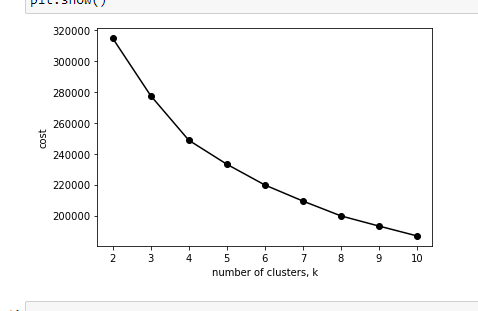

In [33]:
from IPython.display import Image
Image(filename='./img/ModeSil.png')

In [ ]:
# features[0]
# seuclid[0]

plt.figure(figsize=(10,5))
plt.plot(ks,seuclid,label='euclidean')
plt.plot(ks,shamming,label='hamming')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

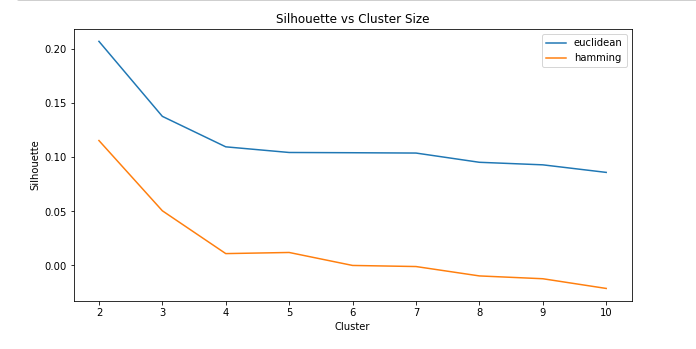

In [34]:
from IPython.display import Image
Image(filename='./img/ModeCS.png')

In [ ]:
cv = StratifiedKFold(n_splits=10)
clf_logreg_modes = LogisticRegression(random_state=1, penalty='l2', C=.01)

y = df_modes['cardio']

ks = range(0,9)

for k in ks:
    X = pd.get_dummies(features[k])
    roc = cross_val_score(clf_logreg_modes, X, y=y, cv=cv, scoring='roc_auc')
    print ("For", k+2, "Clusters:", "Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)

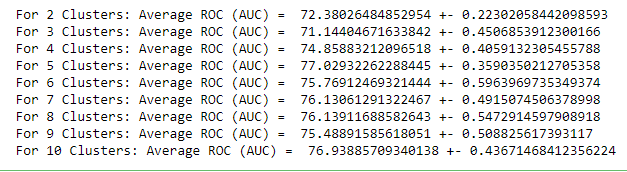

In [35]:
from IPython.display import Image
Image(filename='./img/ModeResults1.png')

In [ ]:
cv = StratifiedKFold(n_splits=10)
clf_logreg_modes = LogisticRegression(random_state=1, penalty='l2', C=.01)

y = df_modes['cardio']

ks = range(0,9)

for k in ks:
    X = pd.get_dummies(features[k])
    roc = cross_val_score(clf_logreg_modes, X, y=y, cv=cv, scoring='accuracy')
    print ("For", k+2, "Clusters:", "Average Accuracy = ", roc.mean()*100, "+-", roc.std()*100)

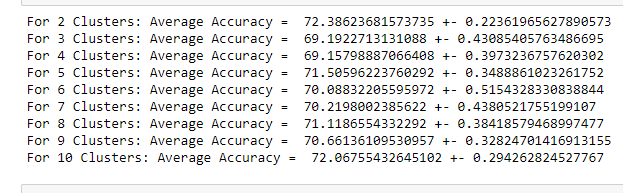

In [36]:
from IPython.display import Image
Image(filename='./img/ModeResults2.png')

Above we see that the best ROC is obtained using 5 clusters, but the best accuracy happens with just 2 clusters. How does this compare to the clustering metrics above? It's hard to tell. We have to keep in mind that clustering metric silhoutte isn't necessarily being optimized for a prediction. This was more of an academic excersise to see how clustering our data before fitting to a logistic regression model might change our classification results. In conclusion, it really doesn't perform better. The results are comparable to what was obtained perviously without clustering.

There are other things to consider. We could have change the initialization parameter. What if we used 50 clusters? What if we change gamma, the weighting between categorical and numerical features?

Below we changed the number of clusters below to 50. We get a higher ROC than before, but accuracy remains about the same.

Additionally, we changed the init param to Cao, for the case of 2 clusters. One observation with this is that it takes signficantly more time than Huang. It's output shows a better ROC value, but accuracy is essentially the same compared to Huang.

In [ ]:
clf_2 = KPrototypes(n_clusters=50, init='Huang', n_init=5, n_jobs=-1, random_state=1)
#clf = KModes(n_clusters=2, init='Huang', n_init=5, n_jobs=-1)
pipe_2 = Pipeline([['ss', StandardScaler()],
                ['clf', clf]])

# Fit model to samples
pipe_2.fit(df_modes, clf__categorical=categories)

# Save off the cluster values
labels_2 = pipe_2['clf'].labels_

In [ ]:
X = pd.get_dummies(labels_2)
roc = cross_val_score(clf_logreg_modes, X, y=y, cv=cv, scoring='roc_auc')
print ("For", 50, "Clusters:", "Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)
roc = cross_val_score(clf_logreg_modes, X, y=y, cv=cv, scoring='accuracy')
print ("For", 50, "Clusters:", "Average Accuracy = ", roc.mean()*100, "+-", roc.std()*100)

In [ ]:
clf_3 = KPrototypes(n_clusters=2, init='Cao', n_init=5, n_jobs=-1, random_state=1)
#clf = KModes(n_clusters=2, init='Huang', n_init=5, n_jobs=-1)
pipe_3 = Pipeline([['ss', StandardScaler()],
                ['clf', clf]])

# Fit model to samples
pipe_3.fit(df_modes, clf__categorical=categories)

# Save off the cluster values
labels_3 = pipe_3['clf'].labels_

In [ ]:
X = pd.get_dummies(labels_3)
roc = cross_val_score(clf_logreg_modes, X, y=y, cv=cv, scoring='roc_auc')
print ("For", 2, "Clusters (Cao Init):", "Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)
roc = cross_val_score(clf_logreg_modes, X, y=y, cv=cv, scoring='accuracy')
print ("For", 2, "Clusters (Cao Init):", "Average Accuracy = ", roc.mean()*100, "+-", roc.std()*100)

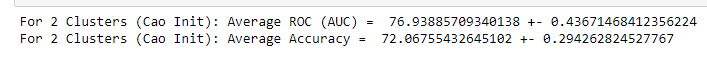

In [37]:
from IPython.display import Image
Image(filename='./img/ModeLast.png')